In [81]:
import sklearn as sk
import sklearn.covariance as cov
import pandas as pd
import numpy as np
from ggplot import *

train_original = pd.DataFrame.from_csv("cleaned_train.csv")
data = train_original.copy()

apply_price_log = True
log_method = np.log
exp_method = np.exp
if apply_price_log:
    data['SalePrice'] = (data['SalePrice']).map(log_method) #'LOGLOGLO'

train = data.as_matrix()
names = data.columns

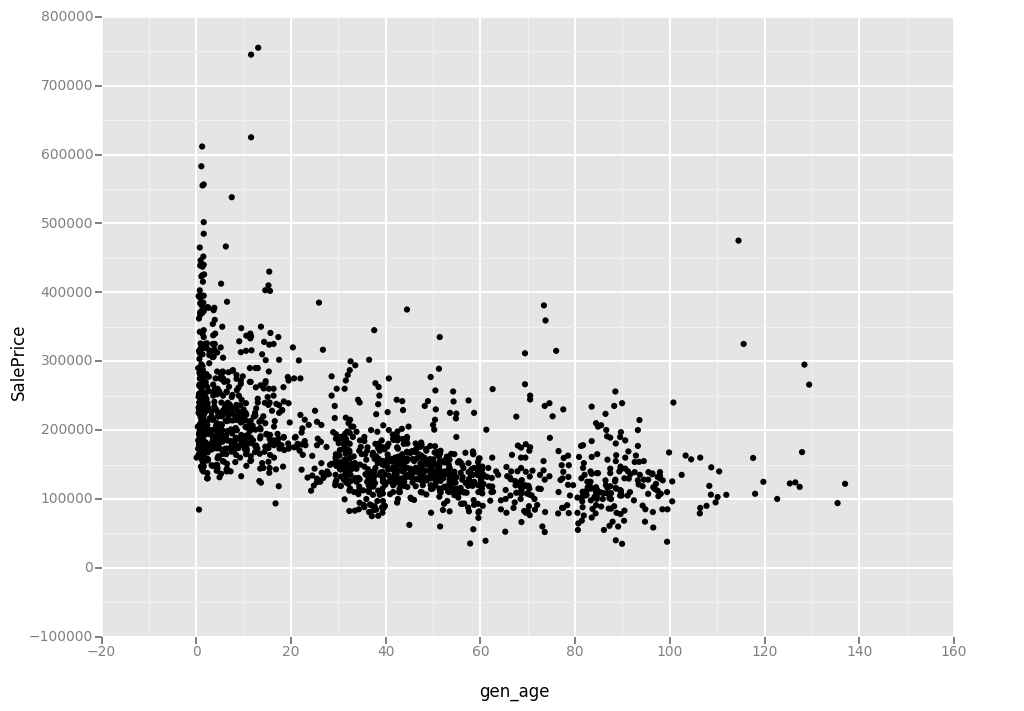

<ggplot: (-9223363302733194303)>

In [82]:
ggplot(train_original,aes(x='gen_age',y='SalePrice')) + geom_point()#stat_smooth(method='lowess')

In [83]:
# Scale some features correctly
#data['OverallQual'] = train_original['OverallQual'].apply(lambda x:x**3)

# Drop features with low variance
import sklearn.feature_selection as sel

thredsh = sel.VarianceThreshold(threshold=0.0) # comparing with plots  0.003 seems to be a good threshold; no it doesn't. dont do it
thredsh.fit(train)
deselected = ~thredsh.get_support()
data = data.drop(names[deselected],axis=1)

# regenerate matrix
train = data.as_matrix()
names = data.columns

In [84]:
import sklearn.preprocessing as pre

# scale all
scaler = pre.RobustScaler()#StandardScaler sucks
train = scaler.fit_transform(train)

In [85]:
# Split the data
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

labels = train[:,0]
features = train[:,1:]

x_train, x_test, y_train, y_test = train_test_split(features,labels,test_size=0.2)

In [86]:
# We learned: neural networks suck balls at predicting house prices. Don't use your brain when buing a house. As you tree.

#from sklearn import ensemble
#from sklearn import neural_network

    #fitter = sk.linear_model.Ridge(alpha=alpha)
    #fitter = sk.linear_model.Lasso(alpha=alpha) #sk.svm.SVR(kernel="linear")
    #fitter = ensemble.RandomForestRegressor()
    #fitter = ensemble.GradientBoostingRegressor(n_estimators=1800,max_leaf_nodes=10,learning_rate=0.005, random_state=1337, loss='ls')
#fitter = neural_network.MLPRegressor(hidden_layer_sizes=(1000,), activation='logistic',solver='sgd', max_iter=500)
    
#scores = cross_val_score(fitter,features,labels,cv=10,scoring='neg_mean_squared_error',n_jobs=4)
#print("RMSE: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))

In [87]:
from sklearn import ensemble



    #fitter = sk.linear_model.Ridge(alpha=alpha)
    #fitter = sk.linear_model.Lasso(alpha=alpha) #sk.svm.SVR(kernel="linear")
#fitter = ensemble.RandomForestRegressor(n_estimators=1000,max_depth=100,max_features="auto",n_jobs=4)
bag_contents = ensemble.GradientBoostingRegressor(
    n_estimators=1800,max_leaf_nodes=15,learning_rate=0.005, random_state=1337, loss='ls')

bag = ensemble.BaggingRegressor(base_estimator=bag_contents, n_jobs=4, random_state=1337)

#scores = cross_val_score(fitter,features,labels,cv=2,scoring='neg_mean_squared_error',n_jobs=4)
#print("RMSE: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))

RMSE: -0.05948 (+/- 0.03584)
RMSE: -0.05971 (+/- 0.03689)
RMSE: -0.06063 (+/- 0.03720)


In [88]:
leaf_data = []
#for i in range(13,21,1):
#    fitter = ensemble.GradientBoostingRegressor(n_estimators=1800,max_leaf_nodes=i,learning_rate=0.005, random_state=78958, loss='ls')
#    leaf_data.append(cross_val_score(fitter,features,labels,cv=12,scoring='neg_mean_squared_error',n_jobs=4))
#print("RMSE: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))

RMSE: -0.08878 (+/- 0.09474) (neue werte, kein log)
RMSE: -0.06129 (+/- 0.03523) (neue werte, log(preise))



In [89]:
bag.fit(features,labels)

BaggingRegressor(base_estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.005, loss='ls', max_depth=3,
             max_features=None, max_leaf_nodes=15,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1800, presort='auto', random_state=1337,
             subsample=1.0, verbose=0, warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=4, oob_score=False,
         random_state=1337, verbose=0, warm_start=False)

In [90]:
#'neg_mean_squared_error'
#from sklearn.metrics import mean_squared_error
#mean_squared_error(y_test,bag.predict(x_test))

In [91]:
#importance = bag.feature_importances_
#sort = np.argsort(importance)[::-1]
#list(zip(importance[sort],names[1:][sort]))

In [92]:
to_predict = pd.DataFrame.from_csv("cleaned_test.csv")
# apply transformations
to_predict = to_predict.drop(train_original.columns[deselected],axis=1)
to_predict_matrix = to_predict.as_matrix()
to_predict_matrix = scaler.transform(to_predict_matrix)

In [93]:
features = to_predict_matrix[:,1:]
labels = bag.predict(features)
prices = scaler.inverse_transform(np.insert(features,0,labels,axis=1))

In [94]:
to_predict['SalePrice'] = prices
if apply_price_log:
    to_predict['SalePrice'] = (to_predict['SalePrice']).map(exp_method)
to_predict[['SalePrice']].to_csv("submission.csv")

In [95]:
to_predict[['SalePrice']]

,SalePrice
Id,
1461,122276.470758
1462,161075.821204
1463,183820.268891
1464,187710.603131
1465,194866.526588
1466,175577.419726
1467,167582.632521
1468,166917.816333
1469,185819.794360
